In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import warnings
warnings.filterwarnings('ignore')
import pymysql
import os
from dotenv import load_dotenv

In [2]:
# load environment variables from .env file
load_dotenv() 
password=os.environ.get('PyMySQL_PASSWORD')
db=os.environ.get('PyMySQL_db')


#connect to my local database
connection = pymysql.connect(host="localhost",
                             user="root",
                             password=password,
                             db=db,
                             port=3306,
                             autocommit=True)

# create a function to return DataFrame with three additional features 
def create_features(df):
    df['month']= df.index.map(lambda x: x.month)
    df['quarter']= df.index.map(lambda x: x.quarter)
    df['year']= df.index.map(lambda x: x.year)
    return df

In [3]:
#create dataframe for website_sessions using sql query in pandas
df_website_sessions = pd.read_sql_query("SELECT * FROM website_sessions",con = connection)

In [4]:
#create dataframe for orders using sql query in pandas
df_orders = pd.read_sql_query("SELECT * FROM orders",con = connection)

In [5]:
df_new = pd.merge(df_website_sessions,df_orders, on = ['website_session_id','user_id'], how = "left")
df_new.rename(columns={'created_at_x':'website_sess_date'  , 'created_at_y': 'order_sess_date'},inplace = True)
df_new.index= pd.to_datetime(df_new.website_sess_date).dt.normalize()
df_new2 = create_features(df_new)

### (1) In order to show the company order volume per overall website session growth by quarter.  I have pulled overall session and order volume, trended by quarter for the life of the business

Text(0.5, 1.0, 'Quarterly Total Website Sessions from 2012 to 2015')

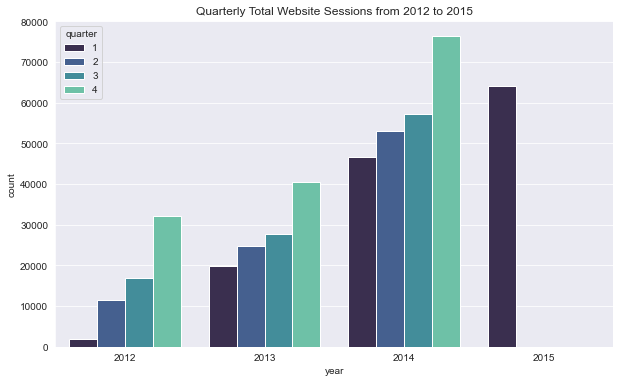

In [6]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))  
sns.countplot(data =df_new2, x= "year",palette= 'mako', hue =  "quarter")
plt.title('Quarterly Total Website Sessions from 2012 to 2015')

### (2) Next, let's showcase all four efficiency improvements.  I've here shown quarterly figures since we launched, for session-to-order conversion rate, revenue per order and revenue per session

In [7]:
# volume of website_session and order grouped by year and quarter using aggfunc 'count'
df_ConvRate= df_new.pivot_table(index =    'year',
                                columns = 'quarter',
                                values = ['website_session_id', 'order_id'],
                                aggfunc = 'count')
# create function to calculate conversion rate
def get_CR_sublist(order,websess):
    ConvR_all = []
    for i in range(1,5):
        OrderSubTot = order[i]
        WebSessCount = websess[i]
        conv_rate = OrderSubTot/WebSessCount
        ConvR_all.append(conv_rate)
    return pd.Series(ConvR_all)
#create final dataframe for 2D/3D lineplot in (2i) Quarterly Session-to-Order Conversion Rate 
CR = df_ConvRate.apply(lambda x: get_CR_sublist(x.order_id, x.website_session_id), axis=1) 
sess2order_T = CR.transpose()
sess2order_T = sess2order_T.rename(index={1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'})
sess2order_T.drop(2015, axis =1,inplace = True)


#define index by datetime
df_orders.index= pd.to_datetime(df_orders.created_at).dt.normalize()
#create additional features using datetime index
df_orders=create_features(df_orders)
# total revenue grouped by year and quarter using aggfunc 'sum'
df_RevperOrd= df_orders.pivot_table(index ='year',
                                columns = 'quarter',
                                values = ['price_usd'],
                                aggfunc = 'sum')
df_RevperOrd = pd.concat([df_ConvRate,df_RevperOrd], axis=1)
df_RevperOrd.rename(columns= {'order_id': 'order_count', 'website_session_id': 'websess_count'  , 'price_usd': 'total_revenue'}, inplace = True)
# create function to calculate quarterly revenue per order
def get_Rev_perOrd(revenue,order):
    Rev_perOrd_all = []
    for i in range(1,5):
        RevSubTot = revenue[i]
        OrdCount = order[i]
        Rev_perOrd = RevSubTot/OrdCount
        Rev_perOrd_all.append(Rev_perOrd)
    return pd.Series(Rev_perOrd_all)
#create final dataframe for 2D/3D lineplot in (2ii) Quarterly Average Revenue per Order
RevperOrd = df_RevperOrd.apply(lambda x: get_CR_sublist(x.total_revenue, x.order_count), axis=1) 
RevperOrd_T = RevperOrd.transpose()
RevperOrd_T = RevperOrd_T.rename(index={0: 'Q1', 1: 'Q2', 2: 'Q3', 3: 'Q4'})
RevperOrd_T.drop(2015, axis =1,inplace = True) # drop incomplete year of 2015


#definte function to calculate average revenue per website session
def get_Rev_perSess(revenue,websess):
    Rev_perSess_all = []
    for i in range(1,5):
        RevSubTot = revenue[i]
        WebSessCount = websess[i]
        Rev_perSess = RevSubTot/WebSessCount
        Rev_perSess_all.append(Rev_perSess)
    return pd.Series(Rev_perSess_all)
#create final dataframe for 2D/3D lineplot in (2iii) Quarterly Average Revenue per Website Session
RevperSess = df_RevperOrd.apply(lambda x: get_CR_sublist(x.total_revenue, x.websess_count), axis=1) 
RevperSess_T = RevperSess.transpose()
RevperSess_T = RevperSess_T.rename(index={0: 'Q1', 1: 'Q2', 2: 'Q3', 3: 'Q4'})
RevperSess_T.drop(2015, axis =1,inplace = True)

# create funtion to make vertex list is a list of (x, y) pairs defining polygon i
def polygon_under_graph(xlist, ylist):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (xlist, ylist) line graph.  Assumes the xs are in ascending order.
    """
    return [(xlist[0], 0.), *zip(xlist, ylist), (xlist[-1], 0.)]


### (2i) Quarterly Session-to-Order Conversion Rate

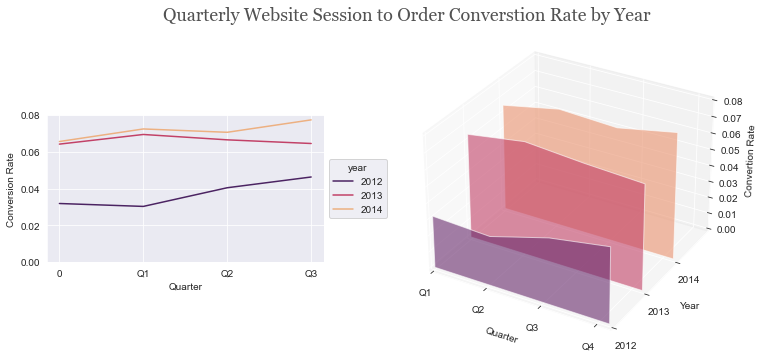

In [8]:
font_color = '#525252'
csfont = {'fontname':'Georgia'} # title font
hfont = {'fontname':'Calibri'} # main font

fig, ax = plt.subplots(3,3,figsize=(10,6))
ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.set_axis_off()
title = plt.title( 'Quarterly Website Session to Order Converstion Rate by Year',  fontsize=18, color=font_color, **csfont)
title.set_position([1.3,0])
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (0, 1), rowspan=3,colspan=3)
ax3.set_axis_off()
ax3 = fig.add_subplot(122, projection='3d')
ax4 = plt.subplot2grid((3, 3), (2, 0))
ax4.set_axis_off()
##############
# 2D lineplot
##############
sess2order_T.plot(ax=ax2, colormap='flare_r') 
ax2.set_xlabel('Quarter')
ax2.set_ylim(0,0.08)
ax2.set_ylabel("Conversion Rate")
ax2.legend(title = 'year', loc='center left', bbox_to_anchor=(1, 0.5))

##############
# 3D lineplot
##############
# verts[i] is a list of (x, y) pairs representing the polygon filling the space under the line graph.
verts = []
# Set up the x sequence
xs = np.linspace(0., 4.0, 4)
# The ith polygon will appear on the plane y = zs[i]
zs = range(3)
new_xticks = np.arange(min(xs), max(xs)+1, 1.25)
new_xlabels =['Q1', 'Q2', 'Q3', 'Q4'] 
new_yticks = np.arange(0,3)
new_ylabels =[2012, 2013, 2014]
for i in zs:
    ys= sess2order_T.iloc[:,i]
    verts.append(polygon_under_graph(xs,ys))
    
facecolors= [ '#682a6c', '#c24167', '#ea926e']
poly = PolyCollection(verts, facecolors=facecolors, alpha=.6)
ax3.add_collection3d(poly, zs=zs, zdir='y')
ax3.set(xlim=(0, 4), ylim=(0, 3), zlim=(0, 0.08),
       xlabel='Quarter', ylabel='Year', zlabel='Convertion Rate')
ax3.set_facecolor('white')
ax3.set_xticks(new_xticks, new_xlabels)  
ax3.set_yticks(new_yticks, new_ylabels)

plt.subplots_adjust(hspace=-0.4,wspace=-0.2, top=0.85, bottom=0.1, left=0.5, right=1.5)
plt.show()

### (2ii) Quarterly Average Revenue per Order

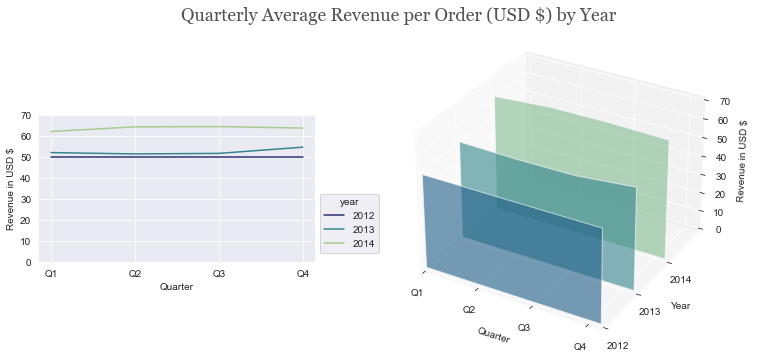

In [9]:
font_color = '#525252'
csfont = {'fontname':'Georgia'} # title font
hfont = {'fontname':'Calibri'} # main font

fig, ax = plt.subplots(3,3,figsize=(10,6))
ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.set_axis_off()
title = plt.title( 'Quarterly Average Revenue per Order (USD $) by Year',  fontsize=18, color=font_color, **csfont)
title.set_position([1.3,0])
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (0, 1), rowspan=3,colspan=3)
ax3.set_axis_off()
ax3 = fig.add_subplot(122, projection='3d')
ax4 = plt.subplot2grid((3, 3), (2, 0))
ax4.set_axis_off()
##############
# 2D lineplot
##############
RevperOrd_T.plot(ax=ax2, colormap='crest_r') 
ax2.set_xlabel('Quarter')
ax2.set_ylim(0,70)
ax2.set_ylabel("Revenue in USD $")
ax2.legend(title = 'year', loc='upper left', bbox_to_anchor=(1, 0.5))
##############
# 3D lineplot
##############
# verts[i] is a list of (x, y) pairs representing the polygon filling the space under the line graph.
verts = []
# Set up the x sequence
xs = np.linspace(0., 4.0, 4)
# The ith polygon will appear on the plane y = zs[i]
zs = range(3)
new_xticks = np.arange(min(xs), max(xs)+1, 1.25)  
new_xlabels =['Q1', 'Q2', 'Q3', 'Q4'] 
new_yticks = np.arange(0,3)
new_ylabels =[2012, 2013, 2014]
facecolors= ['#1e5e87', '#34858d',  '#82bc91']

for i in zs:
    ys= RevperOrd_T.iloc[:,i]
    verts.append(polygon_under_graph(xs,ys))
poly = PolyCollection(verts, facecolors=facecolors, alpha=.6)
ax3.add_collection3d(poly, zs=zs, zdir='y')
ax3.set(xlim=(0, 4), ylim=(0, 3), zlim=(0, 70),
       xlabel='Quarter', ylabel='Year', zlabel='Revenue in USD $')
ax3.set_facecolor('white')
ax3.set_xticks(new_xticks, new_xlabels)  
ax3.set_yticks(new_yticks, new_ylabels)

plt.subplots_adjust(hspace=-0.4,wspace=-0.2, top=0.85, bottom=0.1, left=0.5, right=1.5)
plt.show()

### (2iii) Quarterly Average Revenue per Website Session

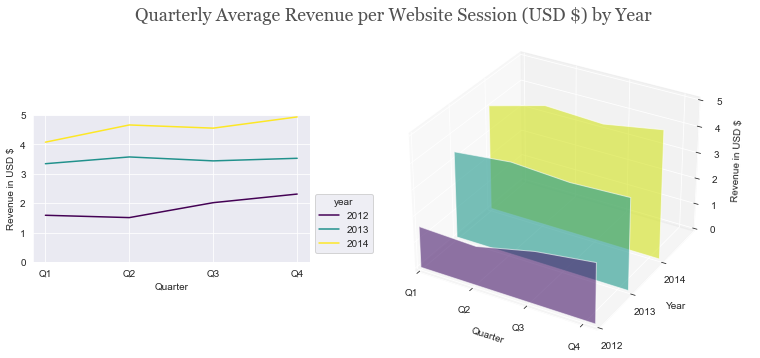

In [10]:
fig, ax = plt.subplots(3,3,figsize=(10,6))
ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.set_axis_off()
title = plt.title( 'Quarterly Average Revenue per Website Session (USD $) by Year',  fontsize=18, color=font_color, **csfont)
title.set_position([1.3,0])
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (0, 1), rowspan=3,colspan=3)
ax3.set_axis_off()
ax3 = fig.add_subplot(122, projection='3d')
ax4 = plt.subplot2grid((3, 3), (2, 0))
ax4.set_axis_off()
##############
# 2D lineplot
##############
RevperSess_T.plot(ax=ax2, colormap='viridis') 
ax2.set_xlabel('Quarter')
ax2.set_ylim(0,5)
ax2.set_ylabel("Revenue in USD $")
ax2.legend(title = 'year', loc='upper left', bbox_to_anchor=(1, 0.5))
##############
# 3D lineplot
##############
# verts[i] is a list of (x, y) pairs representing the polygon filling the space under the line graph.
verts = []
# Set up the x sequence
xs = np.linspace(0., 4.0, 4)
# The ith polygon will appear on the plane y = zs[i]
zs = range(3)
new_xticks = np.arange(min(xs), max(xs)+1, 1.25)
new_xlabels =['Q1', 'Q2', 'Q3', 'Q4'] 
new_yticks = np.arange(0,3)
new_ylabels =[2012, 2013, 2014]
facecolors= ['#481a6c', '#1f988b', '#d2e21b']

for i in zs:
    ys= RevperSess_T.iloc[:,i]
    verts.append(polygon_under_graph(xs,ys))
poly = PolyCollection(verts, facecolors=facecolors, alpha=.6)
ax3.add_collection3d(poly, zs=zs, zdir='y')
ax3.set(xlim=(0, 4), ylim=(0, 3), zlim=(0, 5),
       xlabel='Quarter', ylabel='Year',  zlabel="Revenue in USD $")
ax3.set_facecolor('white')
ax3.set_xticks(new_xticks, new_xlabels)  
ax3.set_yticks(new_yticks, new_ylabels)

plt.subplots_adjust(hspace=-0.4,wspace=-0.2, top=0.85, bottom=0.1, left=0.5, right=1.5)
plt.show()

### (3)This has shown how the company grown specific channels. I have pulled a quarterly view of orders from Gsearch nonbrand, Bsearch nonbrand, brand search overall, organic search, and direct type-in

In [11]:
#create dataframe using sql query in pandas for quarterly order volume by specific channels
query3 ='''
SELECT
	YEAR(orders_by_specific_channels.created_at) AS yr,
    quarter(orders_by_specific_channels.created_at) AS quarter ,
    COUNT(DISTINCT CASE WHEN channels = "gsearch_nonbrand" THEN website_session_id ELSE NULL END) AS gsearch_nonbrand,
    COUNT(DISTINCT CASE WHEN channels = "bsearch_nonbrand" THEN website_session_id ELSE NULL END) AS bsearch_nonbrand,
    COUNT(DISTINCT CASE WHEN channels = "brand_search" THEN website_session_id ELSE NULL END) AS brand_search,
    COUNT(DISTINCT CASE WHEN channels = "organic_search" THEN website_session_id ELSE NULL END) AS organic_search,
	COUNT(DISTINCT CASE WHEN channels = "direct_type_in" THEN website_session_id ELSE NULL END) AS direct_type_in
FROM
(SELECT
	w.created_at,
	-- quarter(w.created_at) AS quarter,
    o.website_session_id,
    CASE
		WHEN utm_source = 'gsearch' AND utm_campaign = "nonbrand" THEN "gsearch_nonbrand"
		WHEN utm_source = 'bsearch' AND utm_campaign = "nonbrand" THEN "bsearch_nonbrand"
		WHEN utm_campaign = "brand" THEN "brand_search"
		WHEN utm_source IS NULL AND utm_campaign IS NULL AND  http_referer IS NOT NULL THEN  "organic_search"
		WHEN utm_source IS NULL AND utm_campaign IS NULL AND  http_referer IS NULL THEN "direct_type_in"
	ELSE "others" END AS channels
FROM
	website_sessions w
LEFT JOIN
	orders o
    ON w.website_session_id = o.website_session_id) AS orders_by_specific_channels
GROUP BY
	YEAR(orders_by_specific_channels.created_at),quarter(orders_by_specific_channels.created_at)
ORDER BY
	YEAR(orders_by_specific_channels.created_at), quarter(orders_by_specific_channels.created_at);
'''
df3 = pd.read_sql_query(query3,con = connection)

In [12]:
idx = []
for i in range(0,len(df3.index)):
    index = (df3.yr[i],f'Q{df3.quarter[i]}')
    idx.append(index)
# create a dataframe with multiIndex
df3.index = pd.MultiIndex.from_tuples(idx)
df3.drop(['yr','quarter'], axis =1,inplace=True)
df3.index.names = ['Year', 'Quarter']
df3 = df3.transpose()
#substact list of dataframes from df3 by year for dfall in clustered stacked barplot
df12= df3.loc[:,2012]
df13= df3.loc[:,2013]
df14= df3.loc[:,2014]
df15= df3.loc[:,2015]

In [13]:
query3_2 ='''
SELECT
	w.created_at,
	-- quarter(w.created_at) AS quarter,
    o.website_session_id,
    CASE
		WHEN utm_source = 'gsearch' AND utm_campaign = "nonbrand" THEN "gsearch_nonbrand" 
		WHEN utm_source = 'bsearch' AND utm_campaign = "nonbrand" THEN "bsearch_nonbrand"
		WHEN utm_campaign = "brand" THEN "brand_search" 
		WHEN utm_source IS NULL AND utm_campaign IS NULL AND  http_referer IS NOT NULL THEN  "organic_search" 
		WHEN utm_source IS NULL AND utm_campaign IS NULL AND  http_referer IS NULL THEN "direct_type_in" 
        ELSE "others" 
    END AS channels
FROM
	website_sessions w
LEFT JOIN
	orders o
    ON w.website_session_id = o.website_session_id;
'''
df3_2 = pd.read_sql_query(query3_2,con = connection)

In [14]:
#create dataframe without grouped by quarter/year for seaborn categorical plots by specific channels
df3_2.index= pd.to_datetime(df3_2.created_at).dt.normalize() 
df3_2 = create_features(df3_2)


In [15]:
# define function to plot clustered stacked barplot
def plot_clustered_stacked(dfall, labels=None, title="Quarterly Total Orders by Channels",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""


    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111) # ncol,nrow, index
    
    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      edgecolor='white',
                      grid=False,
                      **kwargs)  
    # to add artist to each rectangle for stacked bar
    h,l = axe.get_legend_handles_labels()
    for i in range(0, n_df * n_col, n_col): 
        for j, pa in enumerate(h[i:i+n_col]):            
            rects = pa.patches    
            for rect in pa.patches:
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col*2))   
                rect.set_width(1 / float(n_df + 1))
    # to add labels for total order on top of rectangle that's > 500 oders
    for c in axe.containers:
        label = [v.get_height().astype(int) if v.get_height() > 500 else '' for v in c] 
        axe.bar_label(c, labels=label, label_type='edge',color="white",fontweight="bold",padding =5) 
        axe.bar_label(c, labels=label, label_type='edge',color="black",fontweight="bold",padding =5)
        
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(labels = df.index, rotation = 0)    
    axe.set_title(title)
    axe.set_ylim(0,12000)
    axe.set_xlim(-0.5,4.8)
    axe.grid(which='major', alpha=0.9)
    
    #create empty barplot    
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray",edgecolor = 'white', hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[0.9, 0.6] , title= 'quarter')
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[0.9, 0.3], title='year') 
    axe.add_artist(l1) # to add second legend
    return axe


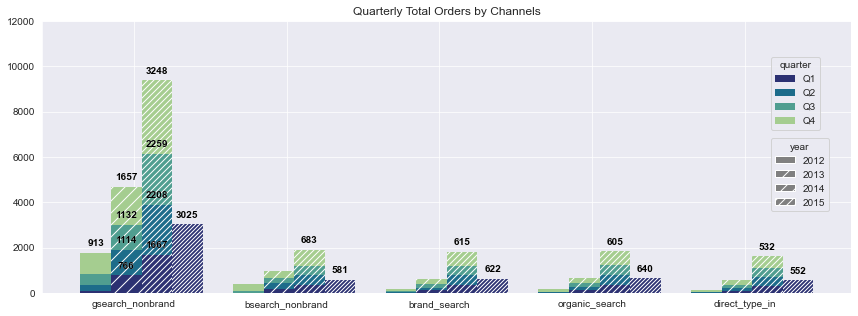

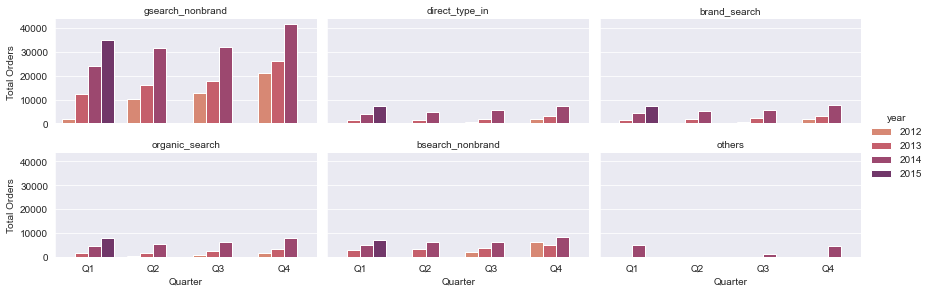

In [16]:
fig, ax = plt.subplots(nrows=2, figsize=(14.5,5))
for pos in ['right', 'top', 'bottom', 'left']:
    ax[0].spines[pos].set_visible(False) # to turn off the frame line of the subplot
ax[0].grid(which='major', alpha=1, color='white')
ax[0].set_facecolor('#eaeaf2')
ax[0].set_ylabel("Total Orders")
plot_clustered_stacked([df12, df13, df14,df15],
                       ["2012", "2013", "2014","2015"],
                       cmap=plt.get_cmap('crest_r'))

sns.set_style('darkgrid')
ax[1] = sns.catplot(x='quarter', kind='count', hue='year', col='channels',col_wrap=3,palette= 'flare', data=df3_2,height=2, aspect=2)
ax[1].set_titles("{col_name}")
ax[1].set_axis_labels("Quarter","Total Orders")
ax[1].set(xticks=np.arange(0,4))
ax[1].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])


plt.show()

### (4)Next, let's show the overall session-to-order conversion rate trends for those same channels, by quarter.

In [17]:
try:
    query4i ='''
    CREATE TEMPORARY TABLE sessions_and_orders_by_specific_channels
    SELECT
        w.created_at,
        -- quarter(w.created_at) AS quarter,
        o.website_session_id AS order_session_id,
        w.website_session_id AS all_session_id,
        CASE
            WHEN utm_source = 'gsearch' AND utm_campaign = "nonbrand" THEN "gsearch_nonbrand"
            WHEN utm_source = 'bsearch' AND utm_campaign = "nonbrand" THEN "bsearch_nonbrand"
            WHEN utm_campaign = "brand" THEN "brand_search"
            WHEN utm_source IS NULL AND utm_campaign IS NULL AND  http_referer IS NOT NULL THEN  "organic_search"
            WHEN utm_source IS NULL AND utm_campaign IS NULL AND  http_referer IS NULL THEN "direct_type_in"
        ELSE "others" END AS channels
    FROM
        website_sessions w
    LEFT JOIN
        orders o
        ON w.website_session_id = o.website_session_id;
    ''' 
    pd.read_sql_query(query4i,con = connection)

except Exception:
    pass
finally:
    query4i ='''
    SELECT
        w.created_at,
        -- quarter(w.created_at) AS quarter,
        o.website_session_id AS order_session_id,
        w.website_session_id AS all_session_id,
        CASE
            WHEN utm_source = 'gsearch' AND utm_campaign = "nonbrand" THEN "gsearch_nonbrand"
            WHEN utm_source = 'bsearch' AND utm_campaign = "nonbrand" THEN "bsearch_nonbrand"
            WHEN utm_campaign = "brand" THEN "brand_search"
            WHEN utm_source IS NULL AND utm_campaign IS NULL AND  http_referer IS NOT NULL THEN  "organic_search"
            WHEN utm_source IS NULL AND utm_campaign IS NULL AND  http_referer IS NULL THEN "direct_type_in"
        ELSE "others" END AS channels
    FROM
        website_sessions w
    LEFT JOIN
        orders o
        ON w.website_session_id = o.website_session_id;
    ''' 
    pd.read_sql_query(query4i,con = connection)

query4ii ='''
SELECT
	YEAR(created_at) AS year,
    quarter(created_at) AS quarter ,
	COUNT(DISTINCT CASE WHEN channels = "gsearch_nonbrand" THEN order_session_id ELSE NULL END) /COUNT(DISTINCT CASE WHEN channels = "gsearch_nonbrand" THEN all_session_id ELSE NULL END) AS gsearch_nonbrand_cr,
    COUNT(DISTINCT CASE WHEN channels = "bsearch_nonbrand" THEN order_session_id ELSE NULL END) / COUNT(DISTINCT CASE WHEN channels = "bsearch_nonbrand" THEN all_session_id ELSE NULL END) AS bsearch_nonbrand_cr,
    COUNT(DISTINCT CASE WHEN channels = "brand_search" THEN order_session_id ELSE NULL END)/COUNT(DISTINCT CASE WHEN channels = "brand_search" THEN all_session_id ELSE NULL END) AS brand_search_cr,
    COUNT(DISTINCT CASE WHEN channels = "organic_search" THEN order_session_id ELSE NULL END)/COUNT(DISTINCT CASE WHEN channels = "organic_search" THEN all_session_id ELSE NULL END) AS organic_search_cr,
	COUNT(DISTINCT CASE WHEN channels = "direct_type_in" THEN order_session_id ELSE NULL END)/COUNT(DISTINCT CASE WHEN channels = "direct_type_in" THEN all_session_id ELSE NULL END) AS direct_type_in_cr
FROM
	sessions_and_orders_by_specific_channels
GROUP BY
	YEAR(created_at),quarter(created_at)
ORDER BY
	YEAR(created_at), quarter(created_at);
'''
df4ii = pd.read_sql_query(query4ii,con = connection)

In [18]:
idx = []
for i in range(0,len(df4ii.index)):
    index = (df4ii.year[i],df4ii.quarter[i])
    idx.append(index)
    
# create a dataframe with multiIndex
df4ii.index = pd.MultiIndex.from_tuples(idx)
df4ii.drop(['year','quarter'], axis =1,inplace=True)
df4ii.drop((2012,1), axis =0,inplace=True)
df4ii.drop([2015], axis =0,inplace=True)
df4ii.index.names = ['Year', 'Quarter']

### Quaterly Overall Session-to-Order Conversion Rate

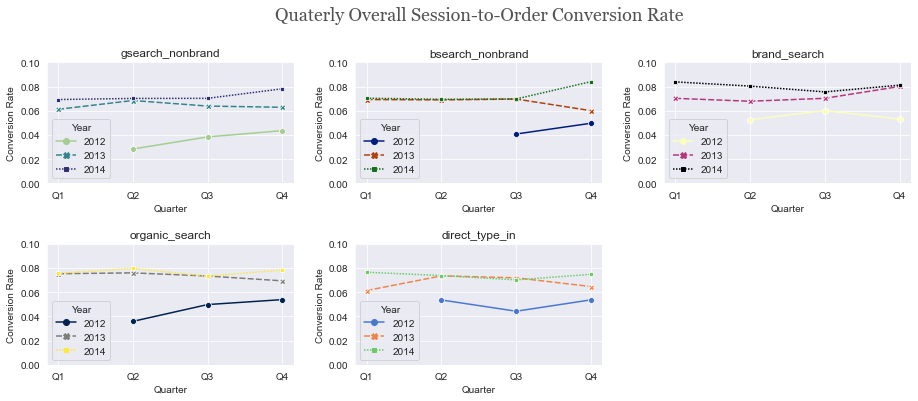

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6),sharey=True)
fig.delaxes(ax[1, 2]) # Remove the empty subplot
colors = ['crest', 'dark', 'magma_r', 'cividis',"muted"]
grdplt = [[(2, 3), (0, 0)],[(2, 3), (0, 1)],[(2, 3), (0, 2)],[(2, 3), (1, 0)],[(2, 3), (1, 1)]] #to identify the subplots 

for i,axs in enumerate(grdplt):
    title = df4ii.columns[i][:-3]
    axs = plt.subplot2grid(grdplt[i][0],grdplt[i][1]) # to plot the lineplot on the specified subplot facegrid
    sns.lineplot(data=df4ii, x=df4ii.index.get_level_values(1), y= df4ii.columns[i], hue=df4ii.index.get_level_values(0), 
         palette=colors[i], markers= True, style =df4ii.index.get_level_values(0), ax=axs)
    axs.set_title(f"{title}")
    axs.set_xticks(np.arange(1,5))
    axs.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
    axs.set_xlabel("Quarter")
    axs.set_ylabel("Conversion Rate")
    axs.set_ylim(0,0.1)

fig.suptitle('Quaterly Overall Session-to-Order Conversion Rate', fontsize=18, color=font_color, **csfont)



plt.subplots_adjust(hspace = 0.5, wspace=0.25, top=0.85, bottom=0.15, left=0.1, right=0.9)

### (5)We’ve come a long way since the days of selling a single product. Let’s pull monthly trending for revenue and margin by product, along with total sales and revenue. Note anything you notice about seasonality.

In [20]:
query5 ='''
SELECT
	YEAR(created_at) AS year,
    MONTH(created_at) AS month,
    SUM(price_usd) AS total_sales,
    SUM(CASE WHEN product_id = 1 THEN price_usd ELSE 0 END) AS sales_prod_1,
	SUM(CASE WHEN product_id = 2 THEN price_usd ELSE 0 END) AS sales_prod_2,
    SUM(CASE WHEN product_id = 3 THEN price_usd ELSE 0 END) AS sales_prod_3,
    SUM(CASE WHEN product_id = 4 THEN price_usd ELSE 0 END) AS sales_prod_4,
	SUM(CASE WHEN product_id = 1 THEN price_usd - cogs_usd ELSE 0 END) AS margin_prod_1,
	SUM(CASE WHEN product_id = 2 THEN price_usd - cogs_usd ELSE 0 END) AS margin_prod_2,
    SUM(CASE WHEN product_id = 3 THEN price_usd - cogs_usd ELSE 0 END) AS margin_prod_3,
    SUM(CASE WHEN product_id = 4 THEN price_usd - cogs_usd ELSE 0 END) AS margin_prod_4

FROM
order_items
GROUP BY
	YEAR(created_at),
    MONTH(created_at) ;

'''
df5 = pd.read_sql_query(query5,con = connection)

In [21]:
#create dataframe of sales for each year for all products 
mo = df5.month
unique_mo = np.unique(mo)
yr = df5.year
unique_yr = np.unique(yr)
prod = ['sales_prod_1','sales_prod_2','sales_prod_3', 'sales_prod_4']
cols = []
for m in range (0, len(prod)):
    for n in range(0,len(unique_yr)): 
        col = (prod[m],unique_yr[n]) # to create tuples for the MultiIndex column
        cols.append(col)     
df_all = pd.DataFrame(index =np.arange(0,13))

for k in range (0, len(prod)): 
    df_prod = pd.DataFrame(columns =[2012,2013,2014,2015])
    for i in range(0, len(unique_mo)):  
        df = df5.loc[df5.month == unique_mo[i] ,['year',prod[k]]]
        df_T = df.transpose()
        df_T.columns= df.year
        df_T.drop('year', axis=0, inplace=True)  
        df_prod = pd.concat([df_prod, df_T], axis =0)
    df_prod.columns = pd.MultiIndex.from_tuples(cols[k*4:(k+1)*4]) 
    df_prod.index = unique_mo
    df_all = pd.concat([df_all,df_prod],axis = 1)
    del df_prod # to delete current df_prod and reset it back to empty df_prod after append it to df_all
    
df_all.columns = pd.MultiIndex.from_tuples(df_all.columns)
df_all.drop(0, axis = 0, inplace = True)

In [22]:
idx = []
for i in range(0,len(df5.index)):
    index = (df5.year[i],df5.month[i])
    idx.append(index)
    
# create a dataframe with multiIndex
df5.index = pd.MultiIndex.from_tuples(idx)
df5.drop((2012,3), axis =0,inplace=True)
df5.drop((2015,3), axis =0,inplace=True)
df5i= df5.copy()
df5.drop(['year','month'], axis =1,inplace=True) 
df5.index = [''.join(str(idx)) for idx in df5.index.values]

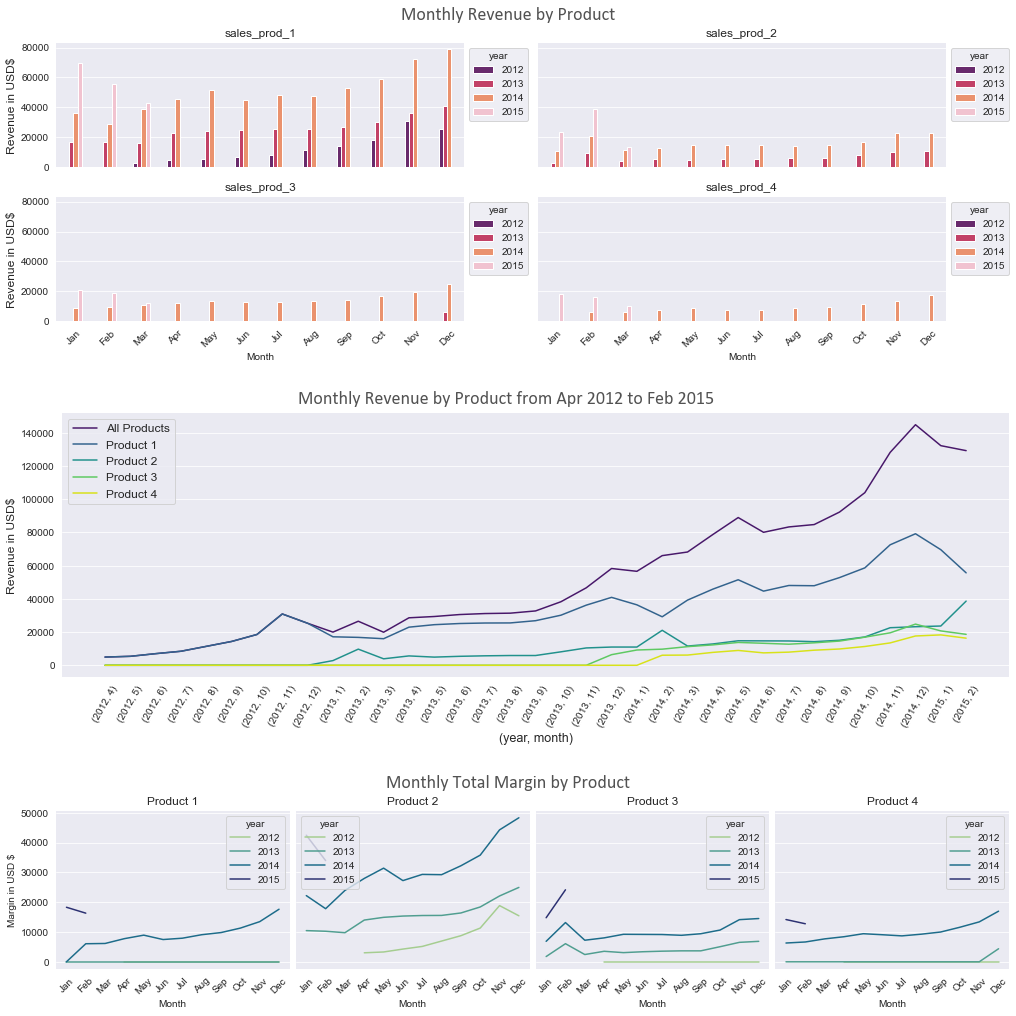

In [23]:
fig = plt.figure(figsize=(14,14),layout="constrained")
subfigs = fig.subfigures(3, 1, hspace=0.07, height_ratios=[1.5, 1.5,1.])

# first subfig: pandas lineplot for monthly revenue for each product 
axs0 = subfigs[0].subplots(2, 2,sharey=True,sharex=True)
y= [2012,2013,2014,2015]
csfont = {'fontname':'Calibri'}
sales_prods = np.unique(df_all.columns.get_level_values(0))
colors = [ '#682a6c', '#c24167', '#ea926e','#f1c3d0']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
i=0
for row in range(2):
    for col in range(2):
        for pos in ['right', 'top', 'bottom', 'left']:
            axs0[row, col].spines[pos].set_visible(False)
        axs0[row, col].grid(which='major', axis='x', alpha=1, color='#eaeaf2')
        axs0[row, col].set_facecolor('#eaeaf2')
        title = sales_prods[i]
        df_all.get(sales_prods[i]).reset_index().plot(x='index', y=y, kind="bar",ax=axs0[row, col],color =colors)                                                     
        i+=1
        axs0[row, col].set_title(f"{title}")
        axs0[row, col].set_xticklabels(months,rotation= 45)
        axs0[row, col].set_xlabel('Month')
        axs0[row, col].set_ylabel('Revenue in USD$', fontsize=12)
        axs0[row, col].legend(loc='upper left',bbox_to_anchor=(1,1), title = 'year')
subfigs[0].suptitle('Monthly Revenue by Product', fontsize= 18, color='#525252', **csfont)

# second subfig: seaborn lineplot for monthly revenue for each product over the years
axs1 = subfigs[1].subplots()
for pos in ['right', 'top', 'bottom', 'left']:
    axs1.spines[pos].set_visible(False)
axs1.grid(which='major', axis='x', alpha=1, color='#eaeaf2')
axs1.set_facecolor('#eaeaf2')
labels = ['All Products','Product 1','Product 2','Product 3', 'Product 4']
colors = [ '#48186a', '#33638d',  '#21918c','#5ec962','#d8e219']
yr_mo = df5.index
for i in range(0,len(df5.columns[:5])):    
    axs1 = sns.lineplot(data=df5, x=df5.index, y= df5.columns[i], label =labels[i],color= colors[i])
axs1.legend(fontsize=12)
axs1.set_xlabel('(year, month)', fontsize=12.5)
axs1.set_ylabel('Revenue in USD$', fontsize=12)
axs1.set_xticklabels(yr_mo,rotation = 60)
subfigs[1].suptitle('Monthly Revenue by Product from Apr 2012 to Feb 2015 ',  fontsize=18, color='#525252', **csfont)

# third subfig: seaborn lineplot for monthly total margin for each product for each year onto facegrid
axs2 = subfigs[2].subplots(ncols= 4, sharey=True)
labels=["Product 1", "Product 2", "Product 3", "Product 4"]  
for i in range(0,len(axs2)):
    for pos in ['right', 'top', 'bottom', 'left']:
        axs2[i].spines[pos].set_visible(False)
        axs2[i].grid(which='major', alpha=1,axis='x', color='#eaeaf2')
    axs2[i].set_facecolor('#eaeaf2')
    title = df5i.columns[i+6]
    sns.lineplot(data=df5i, x=df5i.month, y= df5i.columns[i+6], hue=df5i.year, palette='crest', ax=axs2[i])
    axs2[i].set_title(f"{labels[i]}")
    axs2[i].set_xticks(np.arange(1,13))
    axs2[i].set_xticklabels(months,rotation=45)
    axs2[i].set_xlabel("Month")
    axs2[i].set_ylabel("Margin in USD $")
subfigs[2].suptitle('Monthly Total Margin by Product', fontsize= 18, color='#525252', **csfont)

plt.subplots_adjust(hspace = 0.5, wspace=0.25, top=0.85, bottom=0.15, left=0.1, right=0.8)

plt.show()

### (6) Let’s dive deeper into the impact of introducing new products. Please pull monthly sessions to  the /products page, and show how the % of those sessions clicking through another page has changed over time, along with a view of how conversion from /products to placing an order has improved.

In [24]:
try:       
    query6i ='''
    CREATE TEMPORARY TABLE products_pageviews
    SELECT
        website_session_id, 
        website_pageview_id, 
        created_at AS saw_product_page_at

    FROM website_pageviews 
    WHERE pageview_url = '/products';
    '''
    pd.read_sql_query(query6i,con = connection)
    
except Exception:
    pass

finally:
    query6i ='''
    SELECT
        website_session_id, 
        website_pageview_id, 
        created_at AS saw_product_page_at

    FROM website_pageviews 
    WHERE pageview_url = '/products';
    '''
    pd.read_sql_query(query6i,con = connection)

query6ii ='''
SELECT 
	YEAR(saw_product_page_at) AS yr, 
    MONTH(saw_product_page_at) AS mo,
    COUNT(DISTINCT products_pageviews.website_session_id) AS sessions_to_product_page, 
    COUNT(DISTINCT website_pageviews.website_session_id) AS clicked_to_next_page, 
    COUNT(DISTINCT website_pageviews.website_session_id)/COUNT(DISTINCT products_pageviews.website_session_id) AS clickthrough_rt,
    COUNT(DISTINCT orders.order_id) AS orders,
    COUNT(DISTINCT orders.order_id)/COUNT(DISTINCT products_pageviews.website_session_id) AS products_to_order_rt
FROM products_pageviews
	LEFT JOIN website_pageviews 
		ON website_pageviews.website_session_id = products_pageviews.website_session_id -- same session
        AND website_pageviews.website_pageview_id > products_pageviews.website_pageview_id -- they had another page AFTER
	LEFT JOIN orders 
		ON orders.website_session_id = products_pageviews.website_session_id
GROUP BY 1,2
;
'''
df6ii = pd.read_sql_query(query6ii,con = connection)

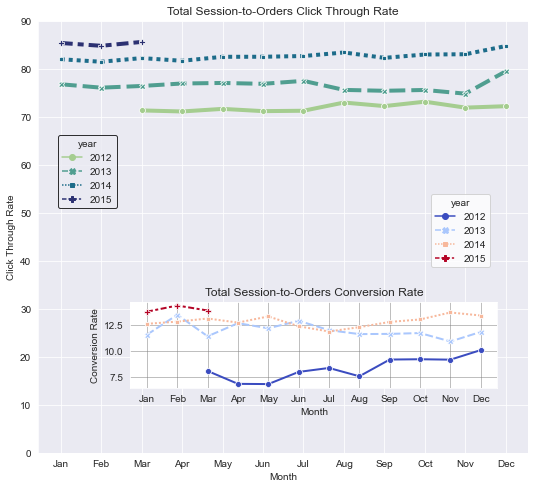

In [25]:
fig = plt.figure(figsize=(8.5,6))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# first subplot: Total Session-to-Orders Click Through Rate
axes1 = fig.add_axes([0, 0.1, 0.8, 1]) # main axes
sns.lineplot(data=df6ii, x=df6ii.mo, y= df6ii.clickthrough_rt*100, hue=df6ii.yr, 
             markers= True,style=df6ii.yr,palette="crest",lw=4, ax=axes1)
axes1.set_title("Total Session-to-Orders Click Through Rate")
axes1.set_ylabel('Click Through Rate')
axes1.set_xlabel('Month')
axes1.set_xticks(np.arange(1,13))
axes1.set_xticklabels(months)
axes1.set_ylim([0,90])
axes1.legend(loc='center left', bbox_to_anchor=(0.03, 0.65),title='year',edgecolor='black')

# second subplot: Total Session-to-Orders Conversion Rate
axes2 = fig.add_axes([0.15, 0.25, 0.6, 0.2]) # insert axes
sns.lineplot(data=df6ii, x=df6ii.mo, y= df6ii.products_to_order_rt*100, hue=df6ii.yr, 
             markers= True,style=df6ii.yr,palette="coolwarm",lw=2, ax=axes2)
axes2.set_title("Total Session-to-Orders Conversion Rate")
axes2.set_facecolor("white")
axes2.set_ylabel('Conversion Rate')
axes2.set_xlabel('Month')
axes2.set_xticks(np.arange(1,13))
axes2.set_xticklabels(months)
axes2.grid(color= 'gray',lw=0.5)
axes2.legend(loc='upper center', bbox_to_anchor=(0.9, 2.3),title='year',facecolor='white')


### (7) We made our 4th product available as a primary product on December 05, 2014 (it was previously only a cross-sell item). Could you please pull sales data since then, and show how well each product cross-sells from one another?


In [26]:
try:
    query7i ='''
    CREATE TEMPORARY TABLE primary_products
    SELECT 
        order_id, 
        primary_product_id, 
        created_at AS ordered_at
    FROM orders 
    WHERE created_at > '2014-12-05' 
    ;

    '''
    pd.read_sql_query(query7i,con = connection)
except Exception:
    pass
finally:
    query7i ='''
    SELECT 
        order_id, 
        primary_product_id, 
        created_at AS ordered_at
    FROM orders 
    WHERE created_at > '2014-12-05' 
    ;

    '''
    pd.read_sql_query(query7i,con = connection)

In [27]:
query7ii ='''
SELECT
	primary_products.*, 
    order_items.product_id AS cross_sell_product_id
FROM primary_products
	LEFT JOIN order_items 
		ON order_items.order_id = primary_products.order_id
        AND order_items.is_primary_item = 0; -- only bringing in cross-sells;

'''
df7ii = pd.read_sql_query(query7ii,con = connection)


In [28]:
df7ii.index= pd.to_datetime(df7ii.ordered_at).dt.normalize()
df7ii = create_features(df7ii)
df_PrimProd = df7ii.pivot_table(index ='primary_product_id',
                                columns = ['year','month'],
                                values = 'order_id',
                                aggfunc= 'count')
# for stacked vertical barplot
df_CrossSellProd = df7ii.pivot_table(index ='cross_sell_product_id',
                                columns = ['year','month'],
                                values = 'order_id',
                                aggfunc= 'count')
df_CrossSellProd.index = df_CrossSellProd.index.astype(int)

#for 3D barplot
df_PrimProd2 = df7ii.pivot_table(index ='primary_product_id',
                                values = 'order_id',
                                aggfunc= 'count')

df_CrossSellProd2 = df7ii.pivot_table(index ='cross_sell_product_id',
                                values = 'order_id',
                                aggfunc= 'count')
df_CrossSellProd2.index = df_CrossSellProd2.index.astype(int)

In [29]:
query7iii ='''

SELECT 
	primary_product_id, 
    COUNT(DISTINCT order_id) AS total_orders, 
    COUNT(DISTINCT CASE WHEN cross_sell_product_id = 1 THEN order_id ELSE NULL END) AS x_sold_p1,
    COUNT(DISTINCT CASE WHEN cross_sell_product_id = 2 THEN order_id ELSE NULL END) AS x_sold_p2,
    COUNT(DISTINCT CASE WHEN cross_sell_product_id = 3 THEN order_id ELSE NULL END) AS x_sold_p3,
    COUNT(DISTINCT CASE WHEN cross_sell_product_id = 4 THEN order_id ELSE NULL END) AS x_sold_p4,
    COUNT(DISTINCT CASE WHEN cross_sell_product_id = 1 THEN order_id ELSE NULL END)/COUNT(DISTINCT order_id) AS p1_xsell_rt,
    COUNT(DISTINCT CASE WHEN cross_sell_product_id = 2 THEN order_id ELSE NULL END)/COUNT(DISTINCT order_id) AS p2_xsell_rt,
    COUNT(DISTINCT CASE WHEN cross_sell_product_id = 3 THEN order_id ELSE NULL END)/COUNT(DISTINCT order_id) AS p3_xsell_rt,
    COUNT(DISTINCT CASE WHEN cross_sell_product_id = 4 THEN order_id ELSE NULL END)/COUNT(DISTINCT order_id) AS p4_xsell_rt
FROM
(
SELECT
	primary_products.*, 
    order_items.product_id AS cross_sell_product_id
FROM primary_products
	LEFT JOIN order_items 
		ON order_items.order_id = primary_products.order_id
        AND order_items.is_primary_item = 0 -- only bringing in cross-sells
) AS primary_w_cross_sell
GROUP BY 1;
'''
df7 = pd.read_sql_query(query7iii,con = connection)

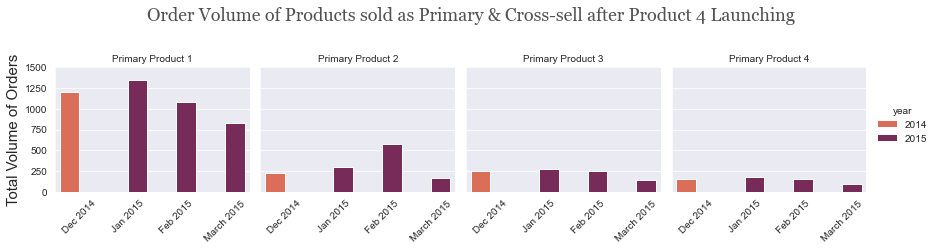

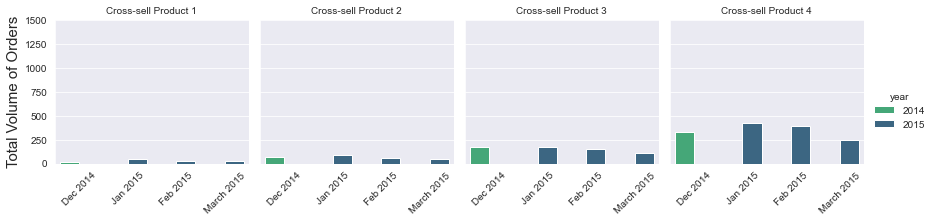

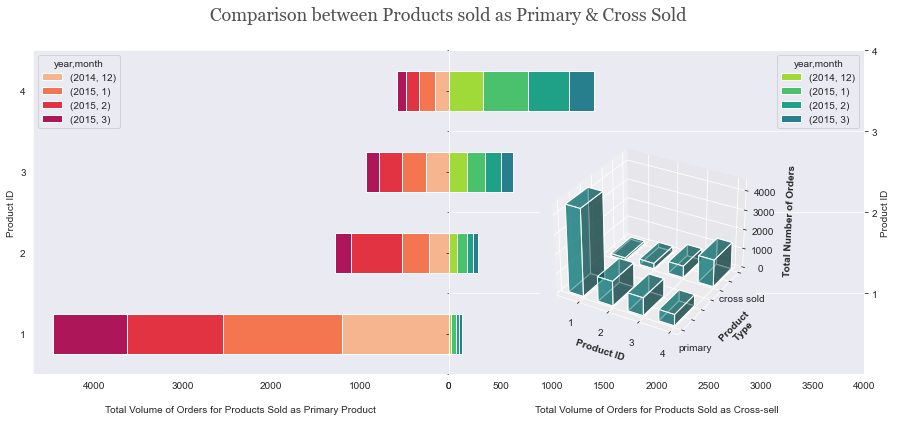

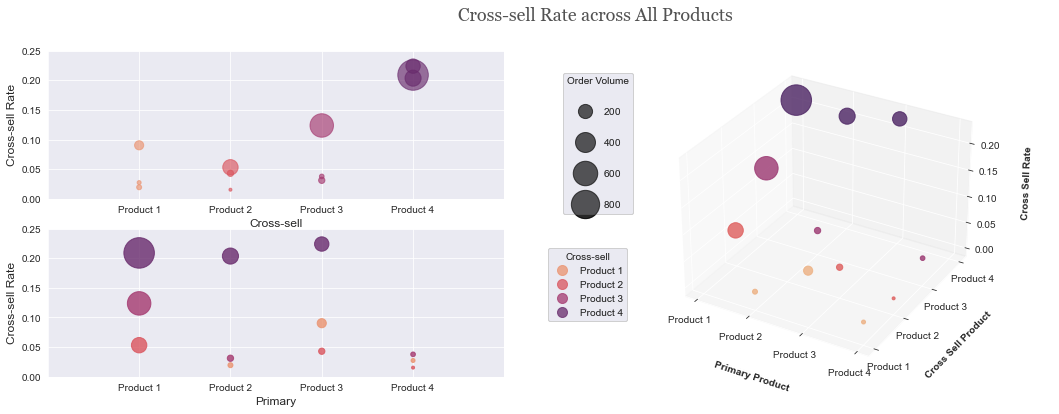

In [30]:
##########################
# Facegrid Seaborn barplots
##########################
font_color = '#525252'
csfont = {'fontname':'Georgia'} 
hfont = {'fontname':'Calibri'} 

g1 = sns.catplot(x='month', kind='count', hue='year', col='primary_product_id',palette= "rocket_r", data=df7ii,order=[12,1,2,3],hue_order=[2014,2015],height=3, aspect=1)
g1.set_titles("Primary Product {col_name}")
g1.set_axis_labels("", "Total Volume of Orders", fontsize= 15)
g1.set_xticklabels(["Dec 2014", "Jan 2015", "Feb 2015", "March 2015"], rotation=45)
g1.set(ylim=(0, 1500))
g1.fig.suptitle('Order Volume of Products sold as Primary & Cross-sell after Product 4 Launching ', fontsize=18, color=font_color, **csfont)
g1.fig.subplots_adjust(top=0.7)

g2 = sns.catplot(x='month', kind='count', hue='year', palette = "viridis_r", col='cross_sell_product_id', data=df7ii,col_order=[1, 2, 3, 4],order=[12,1,2,3],hue_order=[2014,2015],height=2.7, aspect=1.1)
g2.set_titles("Cross-sell Product {col_name}")
g2.set_axis_labels("","Total Volume of Orders", fontsize= 15)
g2.set(ylim=(0, 1500))
g2.set_xticklabels(["Dec 2014", "Jan 2015", "Feb 2015", "March 2015"], rotation=45)

plt.show()

##########################
# stacked vertical barplot
##########################
colors0 = sns.color_palette("rocket_r")
colors1 = sns.color_palette("viridis_r")
column0 = df_PrimProd.columns.get_level_values(1)
column1 = df_CrossSellProd.columns.get_level_values(1)

fig, axes = plt.subplots(figsize=(20,10), ncols=2,sharey=True)
fig.tight_layout()
plt.gca().invert_yaxis()

df_PrimProd.plot.barh(align='center', stacked=True, figsize=(20, 6),color=colors0, ax =axes[0] )
df_CrossSellProd.plot.barh(align='center', stacked=True, figsize=(15, 6),color=colors1,ax= axes[1])


axes[0].invert_xaxis()
axes[0].set_xlabel("\nTotal Volume of Orders for Products Sold as Primary Product")
axes[0].set_ylabel("Product ID")
axes[0].grid(axis='both', alpha=0, color='white')
axes[1].set_xlim(0, 4000) 
axes[1].set_xlabel("\nTotal Volume of Orders for Products Sold as Cross-sell")
axes[1].grid(which = 'both', axis='both', alpha=0, color='white')
axes[1] = axes[1].twinx() 
new_xticks_ = np.arange(1,5)
new_xlabels_ = np.arange(1,5)
plt.yticks(new_xticks_, new_xlabels_)
plt.ylabel('Product ID')
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

#plt.tight_layout()

title = plt.title('Comparison between Products sold as Primary & Cross Sold', pad=30, fontsize=18, color=font_color, **csfont)
title.set_position([0, 1])


##################
# 3D barplot
##################
axes[1] = fig.add_axes([0.6, 0.16, 0.3, 0.5],projection = "3d")
productID = [None,1,2,  3,  4]
product_type = ["",'primary',"","", "","",'cross sold']
data = np.array([np.array(df_PrimProd2.order_id),
                 np.array(df_CrossSellProd2.order_id)])
numOfCols = 4
numOfRows = 2
colors = ['#008080'] 
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)
dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = data.flatten()

axes[1].bar3d(xpos, ypos, zpos, dx, dy, dz, color= colors, alpha=0.5)
axes[1].set_xticklabels(productID)
axes[1].set_yticklabels(product_type)
axes[1].set_xlabel('Product ID', fontsize = 10, fontweight = 'bold')
axes[1].set_ylabel('Product \n Type', fontsize = 10, fontweight = 'bold')
axes[1].set_zlabel('\nTotal Number of Orders', fontsize = 10, fontweight = 'bold')

##################
# 2D scatter plot 
##################

fig, ax = plt.subplots(2,2,figsize=(18,6))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2) #grid for 3D scatter plot
ax3.set_axis_off()
title = plt.title('Cross-sell Rate across All Products', pad=30, fontsize=18, color=font_color, **csfont)
title.set_position([0, 1])

for i in range(0,len(df7.primary_product_id)) : # for each data frame
    x=[f'Product {i+1}' for i in range(0,len(df7.primary_product_id))]
    y=df7.loc[i, ['p1_xsell_rt','p2_xsell_rt' ,'p3_xsell_rt' ,'p4_xsell_rt']]
    cross_sell = df7.loc[i, ['x_sold_p1', 'x_sold_p2', 'x_sold_p3', 'x_sold_p4']]
    colors = ['#ea926e', '#da545d', '#a4386f', '#682a6c'] 

    scatter = ax1.scatter(x, y, s=cross_sell, c=colors, alpha =0.65, label=f'products cross sold with primary product {i+1}' ) 

ax1.set_xlabel('Cross-sell' ,fontsize=12)
ax1.set_ylabel('Cross-sell Rate',fontsize=12)
ax1.set_xlim(-1,4)
ax1.set_ylim(0,0.25)

cross_sells = ['x_sold_p1', 'x_sold_p2', 'x_sold_p3', 'x_sold_p4']
cross_sell_prods =['p1_xsell_rt','p2_xsell_rt' ,'p3_xsell_rt' ,'p4_xsell_rt']
for i in range(0,len(df7.primary_product_id)) : # for each data frame
    x=[f'Product {i+1}' for i in range(0,len(df7.primary_product_id))]
    y=df7[cross_sell_prods[i]]
    cross_sell = df7[cross_sells[i]]
    colors = ['#ea926e', '#da545d', '#a4386f', '#682a6c']
    ax2.scatter(x, y, s=cross_sell, c=colors[i], alpha=0.8, label=f'products cross sold with product {i+1}' ) 

#colors get from sns.color_palette() & palette.as_hex() to match cmap='flare' to indicate same product ID in 2D/3D scatterplots
colors = ["", (0.91781857, 0.57133556, 0.43212486),  (0.85344392, 0.32924217, 0.36533344), (0.64428351, 0.22116972, 0.43389854),(0.40504765, 0.16574261, 0.42072062)]
#customised label for Cross-sell products
c= [i+1 for i in range(0,len(df7.primary_product_id))]*4
unique_c = np.unique(c)
handles = [] 
labels = []
for c_val in unique_c:
    color = colors[c_val]
    handle = plt.Line2D([], [], linestyle='None', markersize=10, marker='o', alpha=0.7, color=color)
    handles.append(handle)
    labels.append('Product ' + str(c_val))

legend1 = ax2.legend(handles, labels, loc='upper right' , bbox_to_anchor=(1.28, 0.9), title="Cross-sell")
ax2.add_artist(legend1)
ax2.set_xlabel('Primary',fontsize=12)
ax2.set_ylabel('Cross-sell Rate',fontsize=12)
ax2.set_xlim(-1,4)
ax2.set_ylim(0,0.25)

##################
# 3D scatter plot
##################
ax3 = fig.add_subplot(122, projection='3d')
x= [i for i in range(1, 5) for _ in range(4)]
y=[i+1 for i in range(0,len(df7.primary_product_id))]*4
z= np.array([df7.loc[i, ['p1_xsell_rt','p2_xsell_rt' ,'p3_xsell_rt' ,'p4_xsell_rt']]for i in range(0,len(df7.primary_product_id))])
z.reshape(-1).tolist()
c= [i+1 for i in range(0,len(df7.primary_product_id))]*4
cross_sell = np.array([df7.loc[i, ['x_sold_p1', 'x_sold_p2', 'x_sold_p3', 'x_sold_p4']] for i in range(0,len(df7.primary_product_id))])
cross_sell.reshape(-1).tolist()

scatter = ax3.scatter(x, y, z, s=cross_sell, c=c , cmap='flare', alpha =0.8)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=6)
legend1 = ax3.legend(handles, labels, loc=[-0.3,0.5], labelspacing=2, title="Order Volume") 
ax3.add_artist(legend1)
ax3.set_xlabel('Primary Product', labelpad= 15, fontsize=10, fontweight = 'bold')
ax3.set_ylabel('Cross Sell Product' ,labelpad= 15, fontsize=10, fontweight = 'bold')
ax3.set_zlabel('Cross Sell Rate',fontsize=10,labelpad= 15, fontweight = 'bold')
ax3.set_facecolor('white')
new_ticks = np.arange(1,5)
new_labels = ["Product 1", "Product 2", "Product 3", "Product 4"]  
plt.xticks(new_ticks, new_labels)  
plt.yticks(new_ticks, new_labels)
plt.tight_layout()

